In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:90%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:10pt;}
div.text_cell_render.rendered_html{font-size:11pt;}
div.output {font-size:10pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:10pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:10pt;padding:5px;}
table.dataframe{font-size:10px;}
</style>
"""))

<b><font size="6" color="red">Ch.9 시계열 데이터 분석</font><b>

		pip install statsmodels==0.13.5 	# 주기적인 데이터의 트렌드 추이
		pip install prophet 		# facebook에서 개발한 시계열 예측 lib

In [2]:
# %pip install statsmodels==0.13.5
%pip show statsmodels

Name: statsmodels
Version: 0.13.5
Summary: Statistical computations and models for Python
Home-page: https://www.statsmodels.org/
Author: 
Author-email: 
License: BSD License
Location: c:\users\admin\anaconda3\envs\ml-dl-nlp\lib\site-packages
Requires: numpy, packaging, pandas, patsy, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [3]:
#%pip install prophet
%pip show prophet

Name: prophet
Version: 1.2.1
Summary: Automatic Forecasting Procedure
Home-page: https://facebook.github.io/prophet/
Author: 
Author-email: "Sean J. Taylor" <sjtz@pm.me>, Ben Letham <bletham@fb.com>
License: MIT
Location: c:\users\admin\anaconda3\envs\ml-dl-nlp\lib\site-packages
Requires: cmdstanpy, holidays, importlib_resources, matplotlib, numpy, pandas, tqdm
Required-by: 
Note: you may need to restart the kernel to use updated packages.


- 측정일시 - 대기지수들
- 지역명 - 대기지수들

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
# 한글설정
plt.rc('font', family='Malgun Gothic') # 윈도우즈에서 시각화 시 한글 깨짐 방지
plt.rc('axes', unicode_minus=False) # 축의 minus(-)깨짐 방지

In [5]:
# AirKorea 사이트에서 다운로드
df = pd.read_csv('data/일별평균대기오염도_2022(에어코리아).csv', encoding='cp949')
df.head()

,측정일시,측정소명,이산화질소농도(ppm),오존농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),미세먼지농도(㎍/㎥),초미세먼지농도(㎍/㎥)
0,20220101,강남구,0.029,0.014,0.5,0.003,25.0,12.0
1,20220101,홍릉로,0.038,0.009,0.6,0.004,27.0,16.0
2,20220101,행주,0.034,0.012,0.7,0.004,27.0,16.0
3,20220101,항동,0.030,0.011,0.5,0.003,27.0,14.0
4,20220101,한강대로,0.037,0.011,0.6,0.003,34.0,14.0


In [6]:
df.info()
# 18250개 데이터 / 365일 = 50개 측정소

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18250 entries, 0 to 18249
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   측정일시          18250 non-null  int64  
 1   측정소명          18250 non-null  object 
 2   이산화질소농도(ppm)  18172 non-null  float64
 3   오존농도(ppm)     18176 non-null  float64
 4   일산화탄소농도(ppm)  18174 non-null  float64
 5   아황산가스농도(ppm)  18176 non-null  float64
 6   미세먼지농도(㎍/㎥)   18115 non-null  float64
 7   초미세먼지농도(㎍/㎥)  18122 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 1.1+ MB


In [7]:
# 미세먼지농도(㎍/㎥) 결측치인 데이터
df[df['미세먼지농도(㎍/㎥)'].isna()]
# 한 열이라도 결측치가 있는 행
df[df.isna().any(axis=1)]

,측정일시,측정소명,이산화질소농도(ppm),오존농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),미세먼지농도(㎍/㎥),초미세먼지농도(㎍/㎥)
287,20220106,남산,0.033,0.015,0.7,0.004,NaN,NaN
339,20220107,남산,0.039,0.016,0.8,0.005,NaN,NaN
387,20220108,남산,0.048,0.011,0.8,0.004,NaN,NaN
437,20220109,남산,0.027,0.024,1.0,0.003,NaN,NaN
490,20220110,남산,0.049,0.012,1.0,0.003,NaN,NaN
...,...,...,...,...,...,...,...,...
15841,20221113,관악산,0.010,0.022,0.3,0.003,NaN,7.0
15842,20221113,관악구,NaN,NaN,NaN,NaN,NaN,NaN
16503,20221127,행주,NaN,NaN,NaN,NaN,24.0,10.0
16591,20221128,관악산,0.008,0.040,0.2,0.003,NaN,9.0


In [8]:
df.loc[df.isna().any(axis=1), '측정소명'].unique()

array(['남산', '세곡', '관악산', '마포아트센터', '서대문구', '도산대로', '북한산', '항동', '동작구',
       '서초구', '동작대로', '행주', '올림픽공원', '동대문구', '송파구', '은평구', '한강대로', '강변북로',
       '시흥대로', '성북구', '관악구'], dtype=object)

In [9]:
df[df['측정소명']=='관악구'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 43 to 18248
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   측정일시          365 non-null    int64  
 1   측정소명          365 non-null    object 
 2   이산화질소농도(ppm)  363 non-null    float64
 3   오존농도(ppm)     363 non-null    float64
 4   일산화탄소농도(ppm)  363 non-null    float64
 5   아황산가스농도(ppm)  363 non-null    float64
 6   미세먼지농도(㎍/㎥)   363 non-null    float64
 7   초미세먼지농도(㎍/㎥)  363 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 25.7+ KB


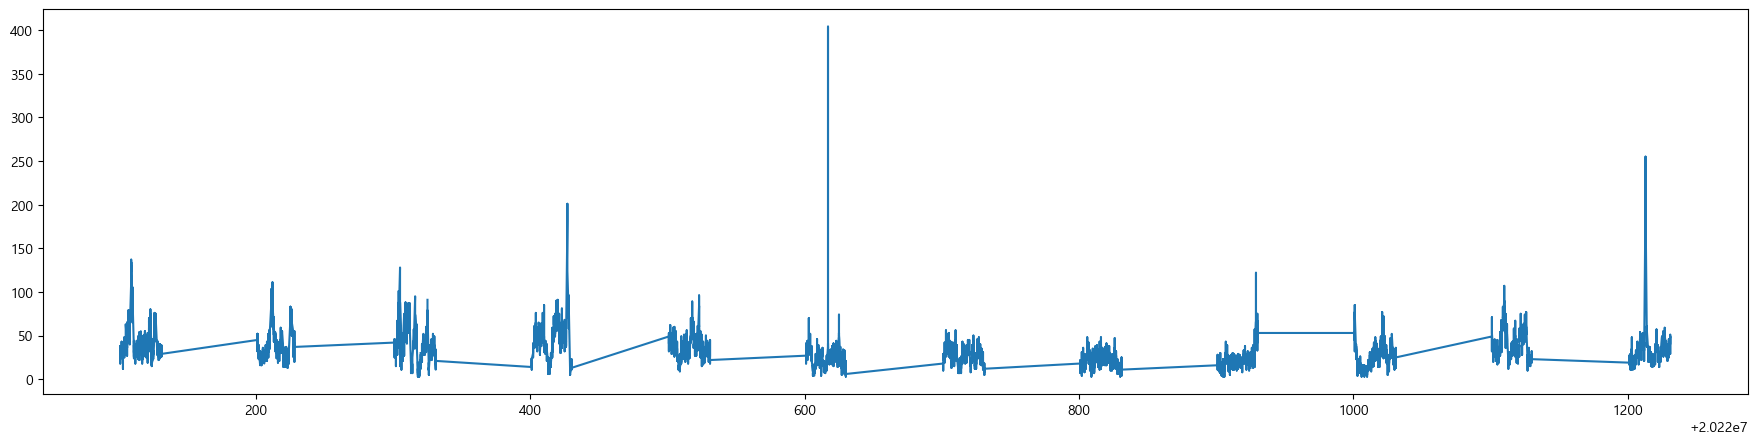

In [10]:
# 전처리 필요해 - 그려 보면 측정일시가 날짜 타입이 아닌 것으로 보임 (위의 df.info()로 봐도 int64)
plt.figure(figsize=(22,5))
plt.plot(df['측정일시'], df['미세먼지농도(㎍/㎥)'])

In [11]:
# 측정일시 컬럼을 날짜형으로 변환
# 20220101 → '2022-01-01' → 날짜변환함수

In [12]:
df['측정일'] = df['측정일시'].astype(str)
df.head(1)

,측정일시,측정소명,이산화질소농도(ppm),오존농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),미세먼지농도(㎍/㎥),초미세먼지농도(㎍/㎥),측정일
0,20220101,강남구,0.029,0.014,0.5,0.003,25.0,12.0,20220101


In [13]:
df['측정일'] = df['측정일'].str[:4] + '-' + df['측정일'].str[4:6] + '-' + df['측정일'].str[6:]

In [14]:
# df['측정일'] = df['측정일'].astype('datetime64[ns]')
df['측정일'] = pd.to_datetime(df['측정일'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18250 entries, 0 to 18249
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   측정일시          18250 non-null  int64         
 1   측정소명          18250 non-null  object        
 2   이산화질소농도(ppm)  18172 non-null  float64       
 3   오존농도(ppm)     18176 non-null  float64       
 4   일산화탄소농도(ppm)  18174 non-null  float64       
 5   아황산가스농도(ppm)  18176 non-null  float64       
 6   미세먼지농도(㎍/㎥)   18115 non-null  float64       
 7   초미세먼지농도(㎍/㎥)  18122 non-null  float64       
 8   측정일           18250 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 1.3+ MB


In [15]:
# 컬럼 정리
cols = df.columns.tolist()
cols = [cols[0], cols[-1]] + cols[1:-1]
df = df[cols]
df.head(1)

,측정일시,측정일,측정소명,이산화질소농도(ppm),오존농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),미세먼지농도(㎍/㎥),초미세먼지농도(㎍/㎥)
0,20220101,2022-01-01,강남구,0.029,0.014,0.5,0.003,25.0,12.0


In [16]:
df = df.drop('측정일시', axis=1).copy()

In [17]:
df.head(1)

,측정일,측정소명,이산화질소농도(ppm),오존농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),미세먼지농도(㎍/㎥),초미세먼지농도(㎍/㎥)
0,2022-01-01,강남구,0.029,0.014,0.5,0.003,25.0,12.0


In [18]:
df.columns = ['측정일', '측정소명', '이산화질소농도', '오존농도', '일산화탄소농도', '아황산가스농도', '미세먼지농도', '초미세먼지농도']
df.sample()

,측정일,측정소명,이산화질소농도,오존농도,일산화탄소농도,아황산가스농도,미세먼지농도,초미세먼지농도
14457,2022-10-17,천호대로,0.017,0.02,0.4,0.003,32.0,12.0


In [23]:
# 결측치 없는 측정소 데이터 추출
df_flt = df[df['측정소명']=='공항대로']

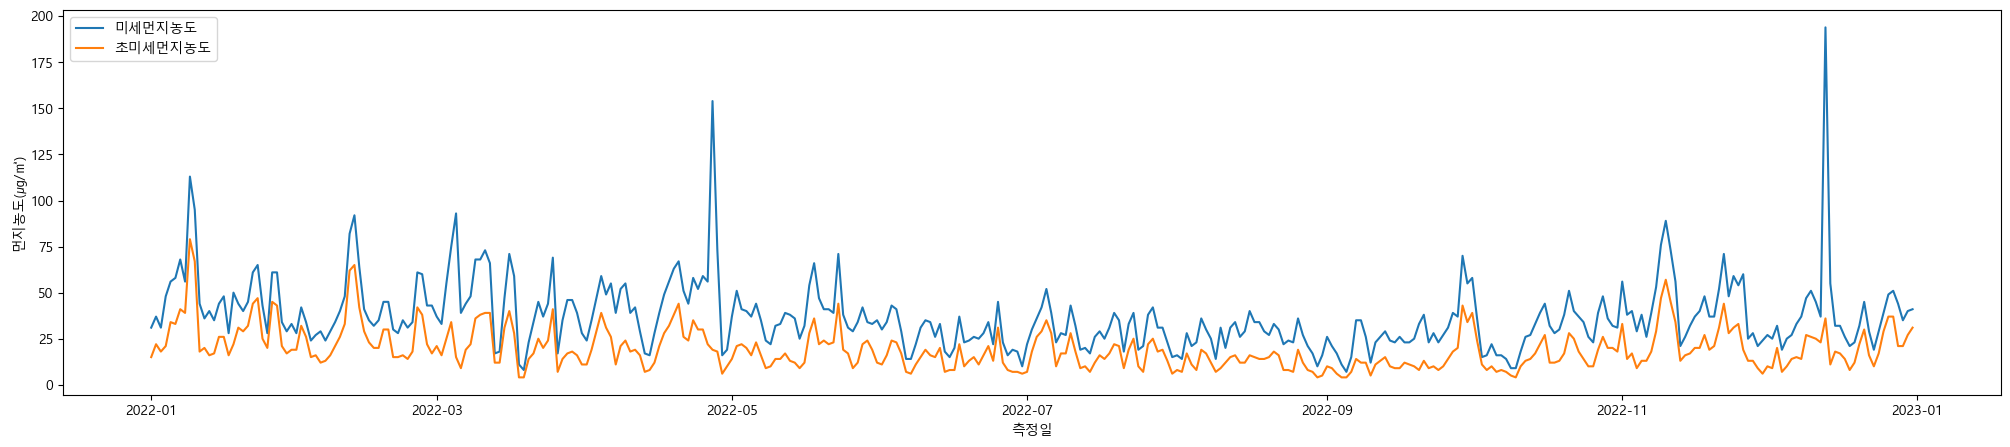

In [24]:
# 미세먼지농도, 초미세먼지농도 시계열 데이터 시각화
plt.figure(figsize=(25,5))
plt.plot(df_flt['측정일'], df_flt['미세먼지농도'], label='미세먼지농도')
plt.plot(df_flt['측정일'], df_flt['초미세먼지농도'], label='초미세먼지농도')
plt.xlabel('측정일')
plt.ylabel('먼지농도(㎍/㎥)')
plt.legend(loc='upper left')
plt.show()

### statsmodels
- (결측치가 없는 데이터에서) 주기적인 데이터의 트렌드 추이 확인
- 날짜형 인덱스와 데이터 컬럼

In [25]:
df_flt.head()

,측정일,측정소명,이산화질소농도,오존농도,일산화탄소농도,아황산가스농도,미세먼지농도,초미세먼지농도
44,2022-01-01,공항대로,0.035,0.010,0.6,0.002,31.0,15.0
93,2022-01-02,공항대로,0.027,0.017,0.5,0.003,37.0,22.0
143,2022-01-03,공항대로,0.041,0.007,0.6,0.003,31.0,18.0
196,2022-01-04,공항대로,0.032,0.010,0.5,0.003,48.0,21.0
244,2022-01-05,공항대로,0.045,0.004,0.8,0.003,56.0,34.0


In [30]:
df_flt2 = df_flt[['측정일', '미세먼지농도']]
ts = df_flt2.set_index('측정일')
ts.head()

,미세먼지농도
측정일,
2022-01-01,31.0
2022-01-02,37.0
2022-01-03,31.0
2022-01-04,48.0
2022-01-05,56.0


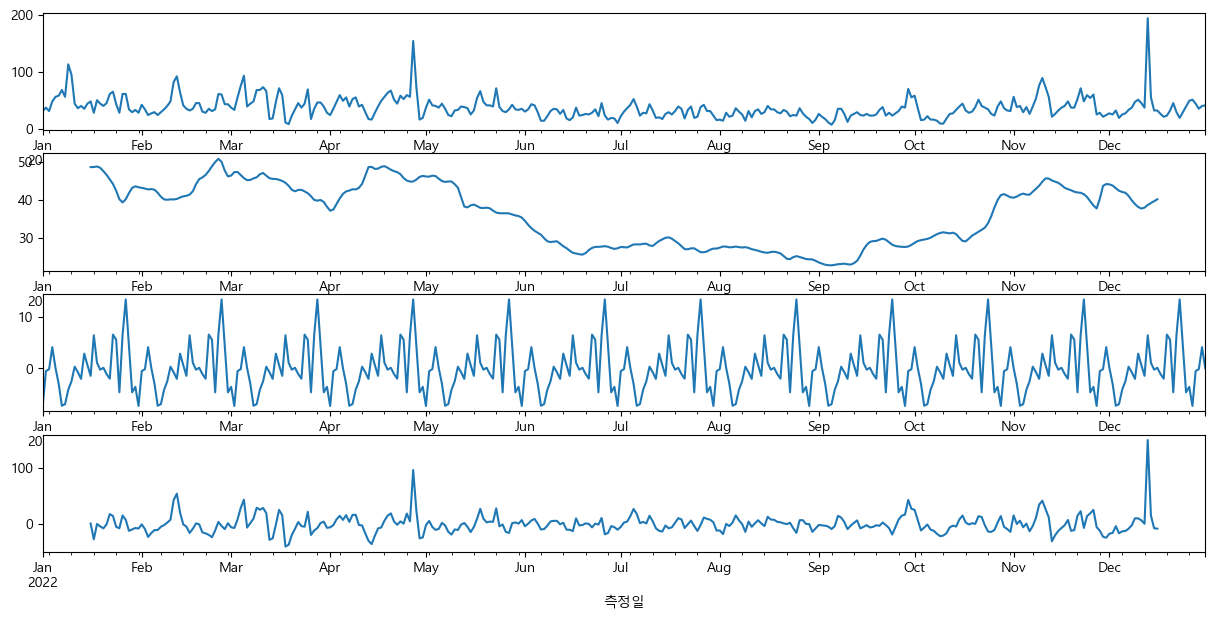

In [39]:
# 시계열 데이터의 구조를 분해하는 도구 : 실제값 추세, 계절성, 잔차(실제 관측값 - 추정 회귀식 예측값)를 분석
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(
    ts['미세먼지농도'], 
    period=30 # 30일 단위로 계절성 분석
)
# result.observed # 실제 관측값
# result.trend # 데이터의 장기적인 변화, 전반적으로 감소, 증가
# result.seasonal # 주기적인 계절성 패턴
# result.resid # 잔차(실제값에서 추세와 계절성을 뺀 노이즈)
fig, axes = plt.subplots(4, 1, figsize=(15, 7))
# axes[0].plot(result.observed)
result.observed.plot(ax=axes[0])
result.trend.plot(ax=axes[1])
result.seasonal.plot(ax=axes[2])
result.resid.plot(ax=axes[3])
plt.show()

cf. 잔차(residual) 오차와의 차이: 
- 오차(Error)는 모집단 전체의 참값과 예측값 사이의 차이를 의미하고, 
- 잔차(Residual)는 모집단 데이터 중 일부인 표본 데이터에서 추정된 회귀식과 실제 관측값 사이의 차이를 말한다.

### Prophet
- 계절성, 추세, 휴일 효과 등을 자동으로 모델, 예측
- 컬럼명 ds(시계열), y(숫자)

In [42]:
df_flt2.columns = ['ds', 'y'] # fit 할 때에 컬럼명 ds, y로 읽음
df_flt2.head(1)

,ds,y
44,2022-01-01,31.0


In [43]:
from prophet import Prophet
# 1. 모델 생성
p_model = Prophet()
# 2. 모델 학습
p_model.fit(df_flt2)

17:49:00 - cmdstanpy - INFO - Chain [1] start processing
17:49:00 - cmdstanpy - INFO - Chain [1] done processing


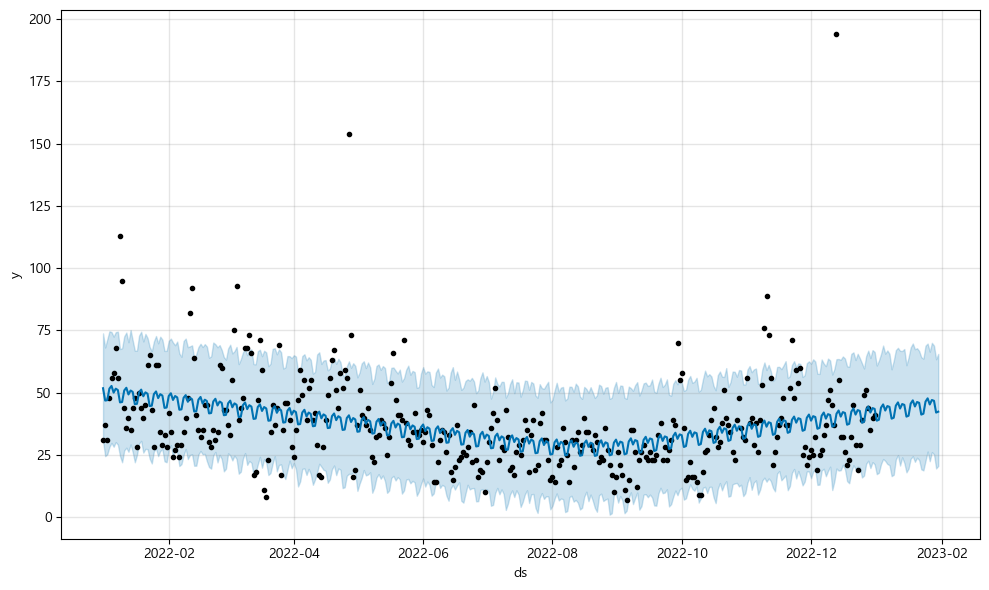

In [47]:
# 3. 30일 이후의 데이터를 예측하는 미래 df 생성
future = p_model.make_future_dataframe(periods=30)
# 4. 예측 수행
forecast = p_model.predict(future)
# forecast.tail(30)
# 5. 시각화
p = p_model.plot(forecast)

In [48]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
365,2023-01-01,38.738264,17.272860,60.896088
366,2023-01-02,39.108784,17.829371,62.863096
367,2023-01-03,43.966999,21.296922,65.476100
368,2023-01-04,45.272272,23.340903,68.914644
369,2023-01-05,42.812966,22.581945,65.655822
370,2023-01-06,44.613397,21.360261,66.944886
371,2023-01-07,44.275891,20.868231,65.589618
372,2023-01-08,39.550926,16.465525,59.367278
373,2023-01-09,39.921445,17.023447,62.816936
374,2023-01-10,44.779660,23.163438,67.077857


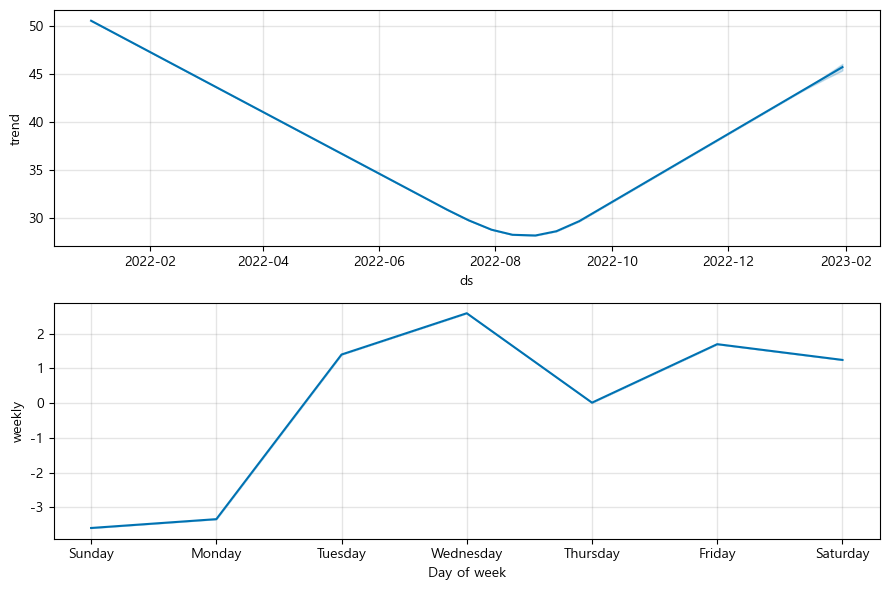

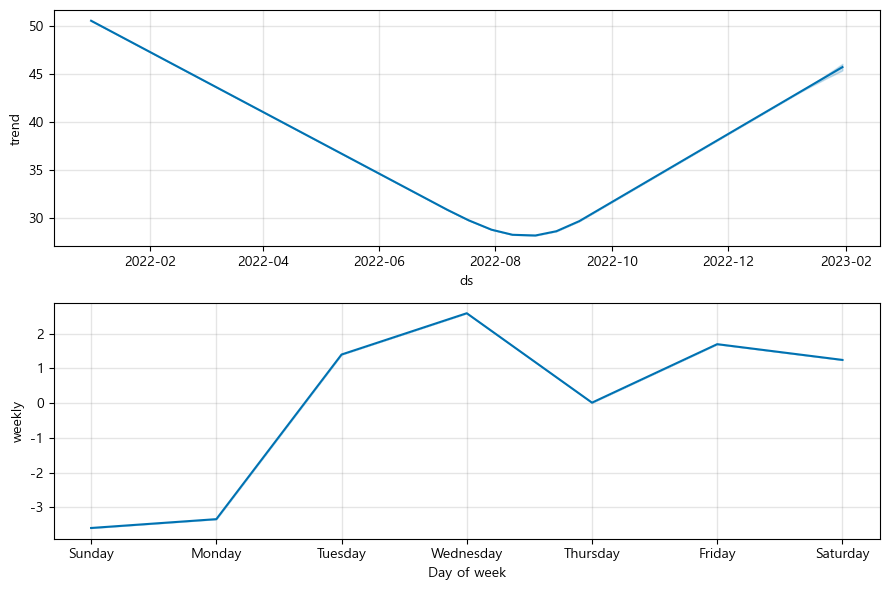

In [49]:
# 트렌드와 휴일 효과
p = p_model.plot_components(forecast)

In [51]:
# 2023-01-12
forecast.loc[forecast['ds']=='2023-01-12', ['ds', 'yhat']]

,ds,yhat
376,2023-01-12,43.625628
